In [1]:
import os
import io
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import h5py
from copy import deepcopy
from functools import reduce

## define helper functions

In [2]:
def set_axes_equal(ax):
    """
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

def unproject_pixels(mask, depth_map, cam_matrix, fx, fy):
    '''
    pts: [N, 2] pixel coords
    depth: [N, ] depth values
    returns: [N, 3] world coords
    '''
    depth = depth_map[mask]
    pts = np.array([[x,y] for x,y in zip(np.nonzero(mask)[0], np.nonzero(mask)[1])])
    camera_matrix = np.linalg.inv(cam_matrix.reshape((4, 4)))

    # Different from real-world camera coordinate system.
    # OpenGL uses negative z axis as the camera front direction.
    # x axes are same, hence y axis is reversed as well.
    # Source: https://learnopengl.com/Getting-started/Camera
    rot = np.array([[1, 0, 0, 0],
                    [0, -1, 0, 0],
                    [0, 0, -1, 0],
                    [0, 0, 0, 1]])
    camera_matrix = np.dot(camera_matrix, rot)


    height = depth_map.shape[0]
    width = depth_map.shape[1]

    img_pixs = pts[:, [1, 0]].T
    img_pix_ones = np.concatenate((img_pixs, np.ones((1, img_pixs.shape[1]))))

    # Calculate the intrinsic matrix from vertical_fov.
    # Motice that hfov and vfov are different if height != width
    # We can also get the intrinsic matrix from opengl's perspective matrix.
    # http://kgeorge.github.io/2014/03/08/calculating-opengl-perspective-matrix-from-opencv-intrinsic-matrix
    intrinsics = np.array([[fx, 0, width/ 2.0],
                           [0, fy, height / 2.0],
                           [0, 0, 1]])
    img_inv = np.linalg.inv(intrinsics[:3, :3])
    cam_img_mat = np.dot(img_inv, img_pix_ones)

    points_in_cam = np.multiply(cam_img_mat, depth.reshape(-1))
    points_in_cam = np.concatenate((points_in_cam, np.ones((1, points_in_cam.shape[1]))), axis=0)
    points_in_world = np.dot(camera_matrix, points_in_cam)
    points_in_world = points_in_world[:3, :].T#.reshape(3, height, width)
    
    return points_in_world

def get_mask_area(seg_img, colors):
    arrs = []
    for color in colors:
        arr = seg_img == color
        arr = arr.min(-1).astype('float32')
        arr = arr.reshape((arr.shape[-1], arr.shape[-1])).astype(bool)
        arrs.append(arr)
    return reduce(np.logical_or, arrs)

def color_image(depth_map, area, color):
    _depth_map = deepcopy(depth_map)
    _depth_map[area] = color
    return _depth_map

## first check if all link trials have centered bases

In [3]:
def composite_pos(stim_path):
    with h5py.File(stim_path, "r") as f:
        # extract object info
        object_ids = np.array(f['static']['object_ids'])
        initial_position = np.array(f['static']['initial_position'])
        initial_rotation = np.array(f['static']['initial_rotation'])
        scales = np.array(f['static']['scale'])
        if "use_base" in np.array(f['static']):
            use_base = np.array(f['static']['use_base'])
            if use_base:
                base_id = np.array(f['static']['base_id'])
                assert base_id.size==1
                base_id = base_id.item()
                base_pos = initial_position[np.where(object_ids==base_id)[0][0]]
                print(base_pos[0], base_pos[2])
        if "use_attachment" in np.array(f['static']):
            use_attachment = np.array(f['static']['use_attachment'])
            if use_attachment:
                attachment_id = np.array(f['static']['attachment_id'])
                assert attachment_id.size==1
                attachment_id = attachment_id.item()
                attachment_pos = initial_position[np.where(object_ids==attachment_id)[0][0]]
                print(attachment_pos[0], attachment_pos[2])
                if "use_cap" in np.array(f['static']):
                    use_cap = np.array(f['static']['use_cap'])
                    if use_cap:
                        cap_id = attachment_id+1
                        cap_pos = initial_position[np.where(object_ids==cap_id)[0][0]]
                        print(cap_pos[0], cap_pos[2])

In [4]:
scenario = 'link'
source_path = '/home/haoliangwang/data/physion_hdf5'
scenario_path = os.path.join(source_path, scenario+'_all_movies')
onlyhdf5 = [f for f in os.listdir(scenario_path) if os.path.isfile(os.path.join(scenario_path, f)) and os.path.join(scenario_path, f).endswith('.hdf5')]

for hdf5_file in onlyhdf5:
    stim_name = hdf5_file[:-5]
    # print(stim_name)
    hdf5_file_path = os.path.join(scenario_path, hdf5_file)
    composite_pos(hdf5_file_path)

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


## check change points

In [ ]:
pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom_small_rings_0011
pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_long_a_0019
pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_long_a_0022
pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_long_a_0034
pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom_small_rings_0036
pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom_small_rings_0036
pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom1_0007
pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom1_0008
pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom1_0020
pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom1_0028
pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom1_0029
pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom1_0035

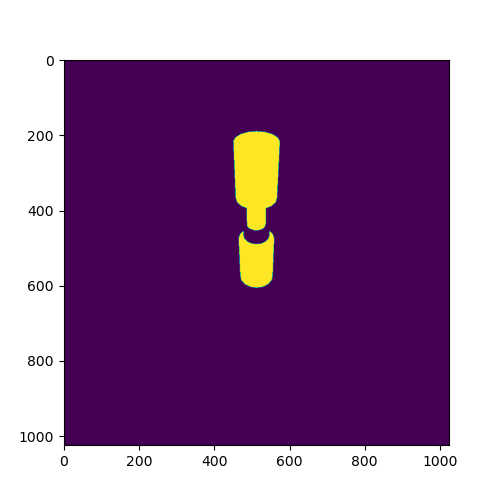

In [69]:
stim_name = 'pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom_small_rings_0036'
hdf5_file_path = f'/home/haoliangwang/data/physion_hdf5/link_all_movies/{stim_name}.hdf5'

vfov = 54.43222 
with h5py.File(hdf5_file_path, "r") as f:
    object_ids = np.array(f['static']['object_ids'])
    object_segmentation_colors = np.array(f['static']['object_segmentation_colors'])

    depth = np.array(f['frames']['0000']['images']['_depth_cam0'])
    im_seg = np.array(Image.open(io.BytesIO(f['frames']['0000']['images']['_id_cam0'][:])))
    height, width = im_seg.shape[0], im_seg.shape[1]

    camera_matrix = np.array(f['frames']['0000']['camera_matrices']['camera_matrix_cam0']).reshape((4, 4))
    projection_matrix = np.array(f['frames']['0010']['camera_matrices']['projection_matrix_cam0']).reshape((4, 4))

    vfov = vfov / 180.0 * np.pi
    tan_half_vfov = np.tan(vfov / 2.0)
    tan_half_hfov = tan_half_vfov * width / float(height)
    fx = width / 2.0 / tan_half_hfov
    fy = height / 2.0 / tan_half_vfov

    fixed_joints = []
    if "use_base" in np.array(f['static']):
        use_base = np.array(f['static']['use_base'])
        if use_base:
            base_id = np.array(f['static']['base_id'])
            assert base_id.size==1
            base_id = base_id.item()
            fixed_joints.append(base_id)
    if "use_attachment" in np.array(f['static']):
        use_attachment = np.array(f['static']['use_attachment'])
        if use_attachment:
            attachment_id = np.array(f['static']['attachment_id'])
            assert attachment_id.size==1
            attachment_id = attachment_id.item()
            fixed_joints.append(attachment_id)
            if "use_cap" in np.array(f['static']):
                use_cap = np.array(f['static']['use_cap'])
                if use_cap:
                    cap_id = attachment_id+1
                    fixed_joints.append(cap_id)
    fixed_joint_ids = np.concatenate([np.where(object_ids==fixed_joint)[0] for fixed_joint in fixed_joints], axis=0).tolist() if fixed_joints else []
    fixed_joint_ids.sort()

for j, o_id in enumerate(fixed_joint_ids):
    this_color = object_segmentation_colors[o_id]
    this_area = get_mask_area(im_seg, [this_color])
    if j == 0:
        consistent_color = this_color
    else:
        im_seg = color_image(im_seg, this_area, consistent_color)

area = get_mask_area(im_seg, [consistent_color])
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)
ax.imshow(area)

In [70]:
point_cloud = unproject_pixels(area, depth, camera_matrix, fx, fy)

In [71]:
len(point_cloud)

36239

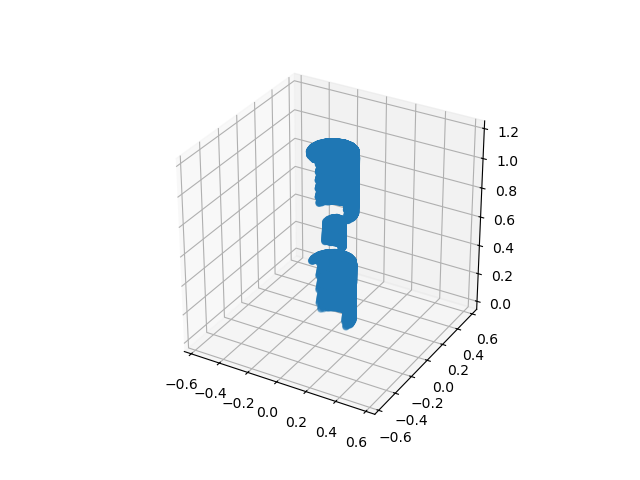

In [72]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_box_aspect([1,1,1])
ax.scatter(point_cloud[:, 0], point_cloud[:,2], point_cloud[:,1])
set_axes_equal(ax)

In [73]:
# Define the tolerance for "close to zero"
tolerance = 0.01

filtered_points = point_cloud[np.abs(point_cloud[:, 0]) <= tolerance]
if filtered_points[:, 2].sum() < 0:
    filtered_points = point_cloud[(np.abs(point_cloud[:, 0]) <= tolerance) & (point_cloud[:, 2] < 0)]
else:
    filtered_points = point_cloud[(np.abs(point_cloud[:, 0]) <= tolerance) & (point_cloud[:, 2] > 0)]

In [74]:
len(filtered_points)

2637

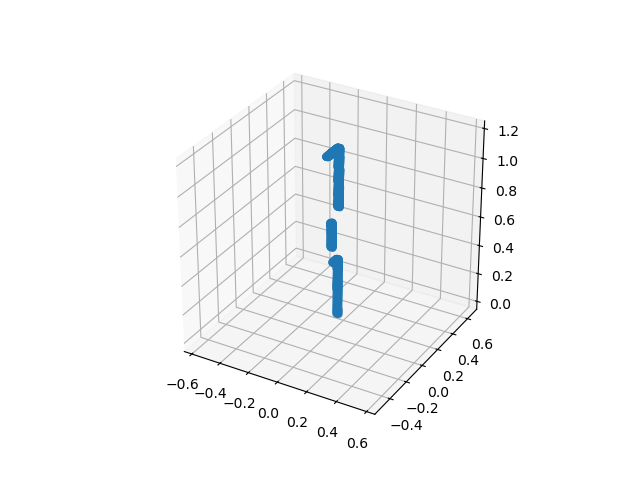

In [75]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_box_aspect([1,1,1])
ax.scatter(filtered_points[:, 0], filtered_points[:,2], filtered_points[:,1])
set_axes_equal(ax)

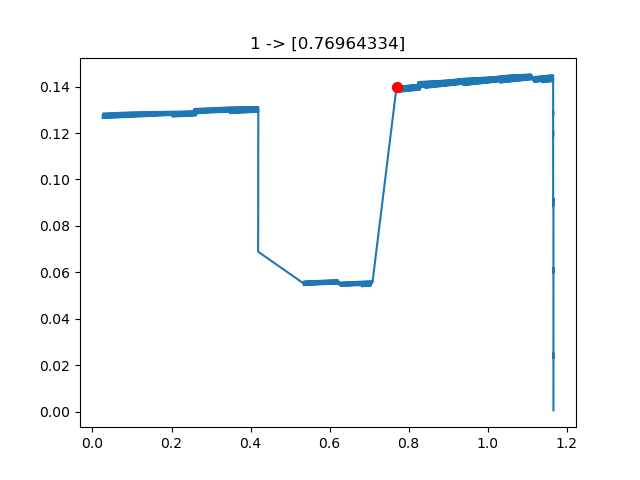

In [76]:
threshold = 0.02
sorted_points = filtered_points

dy = np.abs(np.diff(sorted_points[:, 2]))
spike_indices = np.where(dy > threshold)[0]

merge_distance = 0.02
merged_spikes = []
for idx in spike_indices:
    if not merged_spikes or sorted_points[:, 1][idx] - sorted_points[:, 1][merged_spikes[-1]] > merge_distance:
        merged_spikes.append(idx)

# Plot the data
plt.figure()
plt.plot(sorted_points[:, 1], sorted_points[:, 2])
plt.scatter(sorted_points[:, 1][merged_spikes], sorted_points[:, 2][merged_spikes], color='red', s=50, zorder=5)
plt.title(f'{len(merged_spikes)} -> {sorted_points[:, 1][merged_spikes]}')
plt.show()


In [77]:
# num_pts = 15
# plt.figure()
# plt.plot(sorted_points[:, 1][-15:], sorted_points[:, 2][-15:])

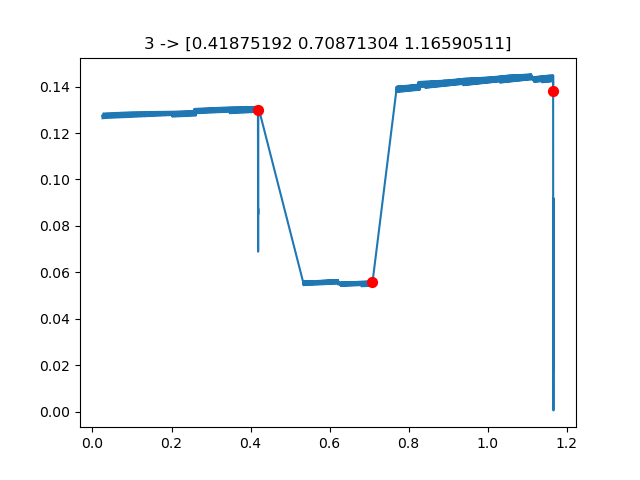

In [78]:
threshold = 0.04
sorted_points = filtered_points[np.argsort(filtered_points[:, 1])]

dy = np.abs(np.diff(sorted_points[:, 2]))
spike_indices = np.where(dy > threshold)[0]

merge_distance = 0.02
merged_spikes = []
for idx in spike_indices:
    if not merged_spikes or sorted_points[:, 1][idx] - sorted_points[:, 1][merged_spikes[-1]] > merge_distance:
        merged_spikes.append(idx)

# Plot the data
plt.figure()
plt.plot(sorted_points[:, 1], sorted_points[:, 2])
plt.scatter(sorted_points[:, 1][merged_spikes], sorted_points[:, 2][merged_spikes], color='red', s=50, zorder=5)
plt.title(f'{len(merged_spikes)} -> {sorted_points[:, 1][merged_spikes]}')
plt.show()

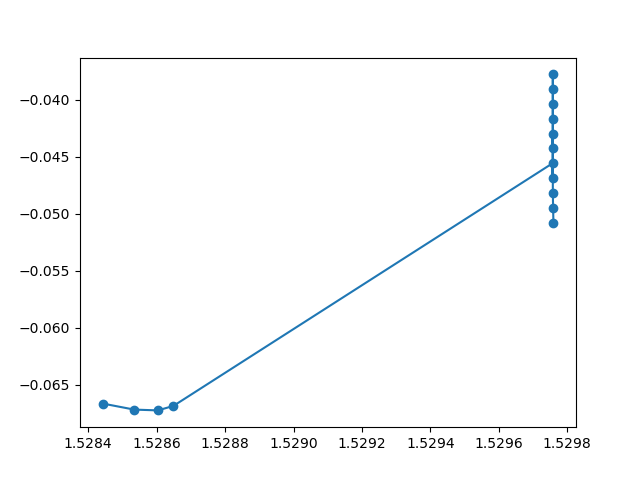

In [68]:
num_pts = 15
plt.figure()
plt.plot(sorted_points[:, 1][-num_pts:], sorted_points[:, 2][-num_pts:], marker='o')

## run in scale

In [3]:
def extract_change_points(hdf5_file_path):
    vfov = 54.43222 
    tolerance = 0.01
    threshold = 0.05
    merge_distance = 0.02
    with h5py.File(hdf5_file_path, "r") as f:
        object_ids = np.array(f['static']['object_ids'])
        object_segmentation_colors = np.array(f['static']['object_segmentation_colors'])

        depth = np.array(f['frames']['0000']['images']['_depth_cam0'])
        im_seg = np.array(Image.open(io.BytesIO(f['frames']['0000']['images']['_id_cam0'][:])))
        height, width = im_seg.shape[0], im_seg.shape[1]

        camera_matrix = np.array(f['frames']['0000']['camera_matrices']['camera_matrix_cam0']).reshape((4, 4))

        vfov = vfov / 180.0 * np.pi
        tan_half_vfov = np.tan(vfov / 2.0)
        tan_half_hfov = tan_half_vfov * width / float(height)
        fx = width / 2.0 / tan_half_hfov
        fy = height / 2.0 / tan_half_vfov

        fixed_joints = []
        if "use_base" in np.array(f['static']):
            use_base = np.array(f['static']['use_base'])
            if use_base:
                base_id = np.array(f['static']['base_id'])
                assert base_id.size==1
                base_id = base_id.item()
                fixed_joints.append(base_id)
        if "use_attachment" in np.array(f['static']):
            use_attachment = np.array(f['static']['use_attachment'])
            if use_attachment:
                attachment_id = np.array(f['static']['attachment_id'])
                assert attachment_id.size==1
                attachment_id = attachment_id.item()
                fixed_joints.append(attachment_id)
                if "use_cap" in np.array(f['static']):
                    use_cap = np.array(f['static']['use_cap'])
                    if use_cap:
                        cap_id = attachment_id+1
                        fixed_joints.append(cap_id)
        fixed_joint_ids = np.concatenate([np.where(object_ids==fixed_joint)[0] for fixed_joint in fixed_joints], axis=0).tolist() if fixed_joints else []
        fixed_joint_ids.sort()

    for j, o_id in enumerate(fixed_joint_ids):
        this_color = object_segmentation_colors[o_id]
        this_area = get_mask_area(im_seg, [this_color])
        if j == 0:
            consistent_color = this_color
        else:
            im_seg = color_image(im_seg, this_area, consistent_color)

    area = get_mask_area(im_seg, [consistent_color])
    point_cloud = unproject_pixels(area, depth, camera_matrix, fx, fy)

    filtered_points = point_cloud[np.abs(point_cloud[:, 0]) <= tolerance]
    if filtered_points[:, 2].sum() < 0:
        filtered_points = point_cloud[(np.abs(point_cloud[:, 0]) <= tolerance) & (point_cloud[:, 2] < 0)]
    else:
        filtered_points = point_cloud[(np.abs(point_cloud[:, 0]) <= tolerance) & (point_cloud[:, 2] > 0)]

    sorted_points = filtered_points[np.argsort(filtered_points[:, 1])]

    dy = np.abs(np.diff(sorted_points[:, 2]))
    spike_indices = np.where(dy > threshold)[0]

    merged_spikes = []
    for idx in spike_indices:
        if not merged_spikes or sorted_points[:, 1][idx] - sorted_points[:, 1][merged_spikes[-1]] > merge_distance:
            merged_spikes.append(idx)
    return sorted_points, merged_spikes

In [4]:
scenario = 'link'
source_path = '/home/haoliangwang/data/physion_hdf5'
scenario_path = os.path.join(source_path, scenario+'_all_movies')
onlyhdf5 = [f for f in os.listdir(scenario_path) if os.path.isfile(os.path.join(scenario_path, f)) and os.path.join(scenario_path, f).endswith('.hdf5')]

for hdf5_file in onlyhdf5:
    stim_name = hdf5_file[:-5]
    print(stim_name)
    hdf5_file_path = os.path.join(scenario_path, hdf5_file)
    sorted_points, spike_indices = extract_change_points(hdf5_file_path)

    plt.figure()
    plt.plot(sorted_points[:, 1], sorted_points[:, 2])
    plt.scatter(sorted_points[:, 1][spike_indices], sorted_points[:, 2][spike_indices], color='red', s=50, zorder=5)
    plt.title(f'{len(spike_indices)} -> {sorted_points[:, 1][spike_indices]}')
    plt.savefig(f"/home/haoliangwang/b3d/temp/{stim_name}.png")
    plt.close()

pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom_small_rings_0029
pilot_linking_nl6_aNone_bCone_occ1_dis1_boxroom_0001
pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_0011
pilot_linking_nl6_aNone_bCone_occ1_dis1_boxroom_0030
pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom1_0037
pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom1_0034
pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_0009
pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_long_a_0012
pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom1_long_a_0000
pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom_small_rings_long_a_0030
pilot_linking_nl1-8_mg000_aCyl_bCyl_tdwroom_small_rings_0023
pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom1_0035
pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom1_0012
pilot_linking_nl1-8_mg000_aCylcap_bCyl_tdwroom_small_rings_0036
pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom_small_rings_0006
pilot_linking_nl6_aNone_bCone_occ1_dis1_boxroom_0021
pilot_linking_nl2-3_mg01_aCone_bCyl_boxroom_0038
pilot_linking_nl1-8_mg000_aNone_bCyl_tdwroom1_003